<a href="https://colab.research.google.com/github/kevinCortial/graphlearning/blob/main/Product_Space/processing_PS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> Graph Learning on Product Space </center></h1>

<center> Kévin CORTIAL et Taoufik JARMOUNI &nbsp;&nbsp;&nbsp; | &nbsp;&nbsp;&nbsp; Open Studio UCA IP / Atlas des Synergies Productives &nbsp;&nbsp;&nbsp; </center>

Product Space : 

Download : https://github.com/apachot/Knowhow_proximities/blob/main/input/HS_similarity_usingCF.csv

This graph represents the proximity of industrial know-how between the product classes of the HS nomenclature, independently of the country or territory observed. This graph was built by the analysis of thousands of websites of French companies to label the products they manufacture. From these collected data, a recommendation system, based on collaborative filtering, has allowed to establish links between the products of the HS nomenclature that have the strongest productive proximity.

In [ ]:
pip install networkx==2.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.2 MB/s 
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

from community import community_louvain
from google.colab import drive
from sklearn import metrics
from random import *

In [ ]:
seed(35456)

In [ ]:
#This cell allows us to grab our needed resources from Google Drive directly

drive.mount('/content/drive')

Mounted at /content/drive


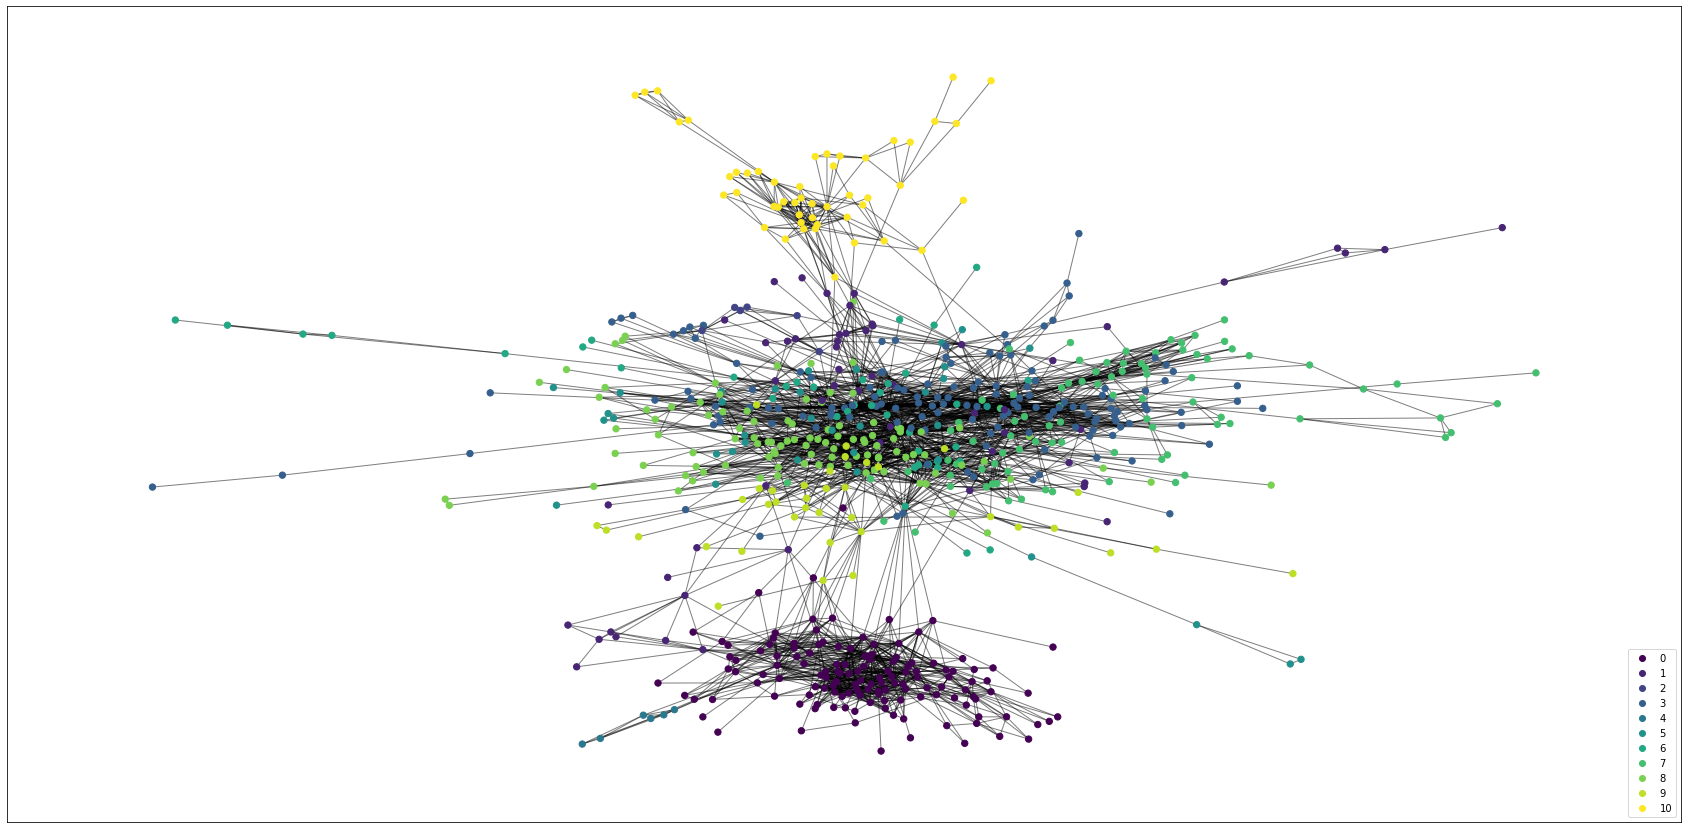

In [ ]:
def get_louvain_graph_from_G(G):
  # Louvain partition
  partition = community_louvain.best_partition(G)

  pos = nx.spring_layout(G)

  # Color the nodes according to their partition
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
  nodes = nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(partition.values()))
  nx.draw_networkx_edges(G, pos, alpha=0.5)

  # Legend creation
  values = sorted(list(set(partition.values())))
  for v in values:
      # Make dummy scatterplot to generate labels
      plt.gca().scatter([],[], color=nodes.cmap(v/np.max(values)), label=v)
      
  plt.legend(loc='lower right')
  fig = plt.gcf()
  fig.set_size_inches(30, 15)
  plt.show()
  return partition

G = nx.read_gpickle("/content/drive/MyDrive/ColabNotebooks/graphOriginal.gpickle")
partition = get_louvain_graph_from_G(G)

In [ ]:
# This cell allows us to import stopwords so we can use them later on to clean up the products' descriptions

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

stop_words_fr = stopwords.words("french")
stop_words_en = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


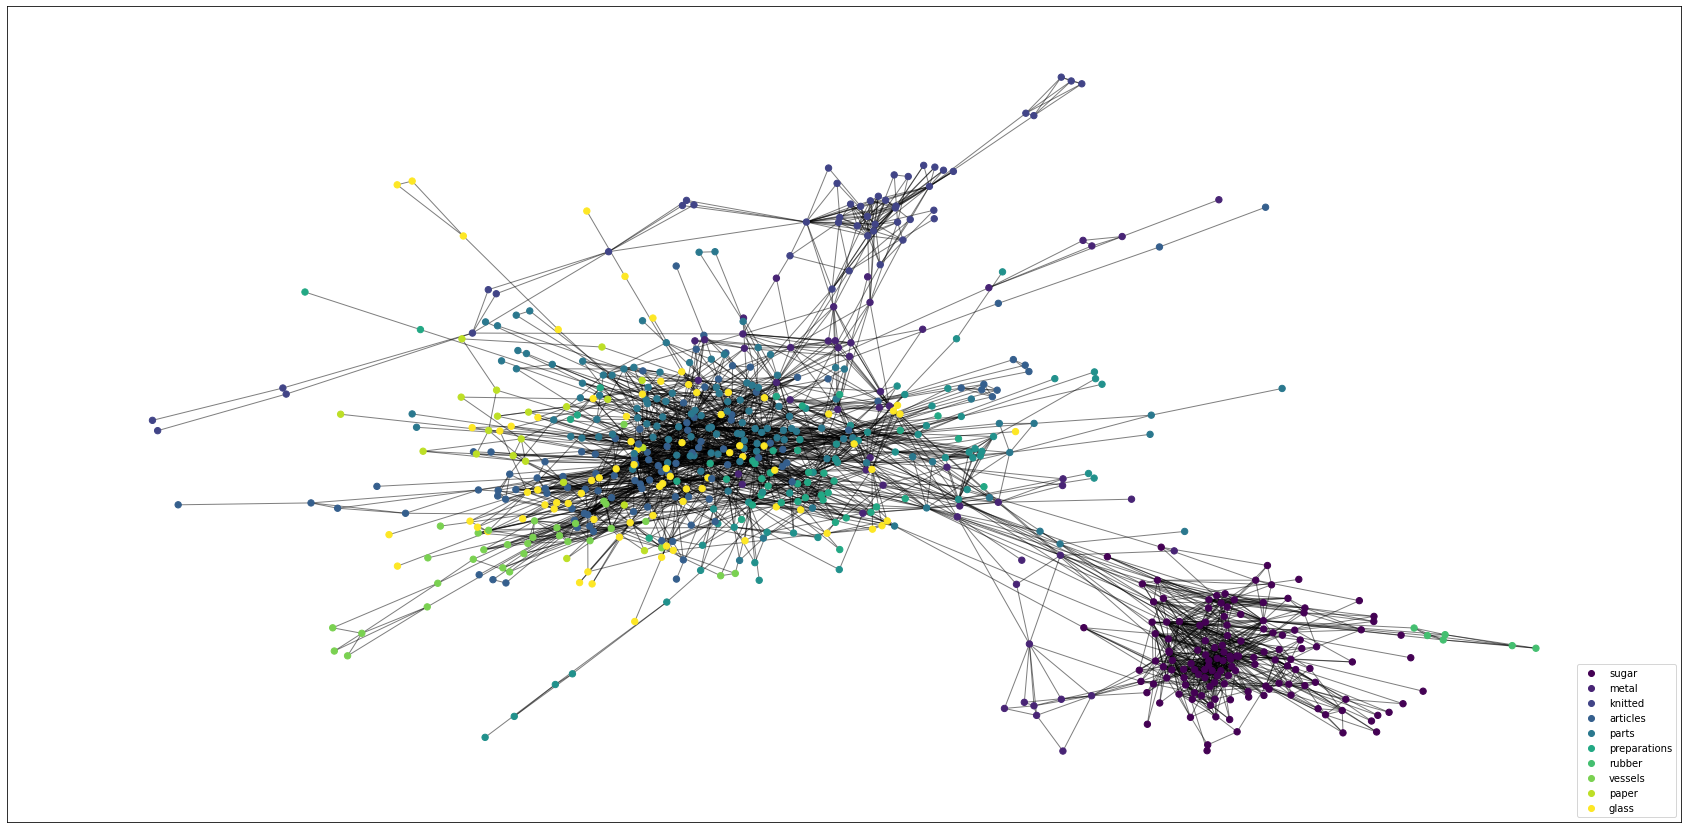

In [ ]:
# This cell allows us to get the most frequent words in every cluster, by using the Counter library. Every cluster is made of a combination of all the member products' strings
# of course all those strings are cleaned afterwards thanks to a preset and customized stopword list.
# This can be done in both english and french, all its needed is to comment the two english lines and uncomment the french ones.
# This code can also show us wordclouds of each cluster, with the top 20 most frequent words of each one.

from collections import Counter

def load_dataframe():
  df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/product_nomenclature_cleaned.csv', delimiter = "|", dtype={'code_hs4': str})
  return df


def english_processing(partition, df, stop_words_en, maximum, most_common_words):
  partition = replace_code_with_english_description(partition, df)
  most_common_words = get_english_most_common_words(stop_words_en, maximum, partition)
  return most_common_words


def french_processing(partition, df, stop_words_fr, maximum, most_common_words):
  partition = replace_code_with_french_description(partition, df)
  most_common_words = get_french_most_common_words(stop_words_fr, maximum, partition)
  return most_common_words


def replace_code_with_english_description(partition, df):
  for k in list(partition.items()):
    element = list(k)
    old_element = element[0]
    test = df.loc[(df['code_hs4'] == element[0]).idxmax(),'name_en']
    element[0] = test
    new_value = list(partition.items())
    partition[element[0]] = partition.pop(old_element)
  return partition


def replace_code_with_french_description(partition, df):
  for k in list(partition.items()):
    element = list(k)
    old_element = element[0]
    test = df.loc[(df['code_hs4'] == element[0]).idxmax(),'name_fr']
    element[0] = test
    new_value = list(partition.items())
    partition[element[0]] = partition.pop(old_element)
  return partition


def get_number_of_partitions(partition):
  new_val = partition.values()
  maximum = max(new_val)
  return maximum


def get_english_most_common_words(stop_words_en, maximum, partition):
  common_words_lst = []
  for i in range(0,maximum):
    first_category = [k for k,v in partition.items() if v == i]
    string_category = ' '.join(first_category)
    stop_words_en.extend(["(excl.", "whether", "<=", "kg)", "n.e.s.", "incl.", "thereof", "containing", "similar"])
    string_category = ' '.join([w for w in string_category.split() if w not in stop_words_en])
    #counts = Counter(string_category.split()).most_common(20)
    counts = Counter(string_category.split()).most_common(1)
    cat = dict(counts)
    res = list(cat.keys())[0]
    common_words_lst.append(res)
    #get_wordcloud(string_category)
  most_common_words.update(cat)
  return common_words_lst


def get_french_most_common_words(stop_words_fr, maximum, partition):
  for i in range(0,maximum):
    common_words_lst = []
    first_category = [k for k,v in partition.items() if v == i]
    string_category = ' '.join(first_category)
    stop_words_fr.extend(["(à.", "simil.", "autres", "non", "cm", "(à", "lexcl.", "(sauf", "autre", "<="])
    string_category = ' '.join([w for w in string_category.split() if w not in stop_words_fr])
    #counts = Counter(string_category.split()).most_common(20)
    counts = Counter(string_category.split()).most_common(1)
    cat = dict(counts)
    res = list(cat.keys())[0]
    common_words_lst.append(res)
    #get_wordcloud(string_category)
  most_common_words.update(cat)
  return common_words_lst


def get_legend_graph_from_G(G, most_common_words):
  # draw the graph
  pos = nx.spring_layout(G)
  # color the nodes according to their partition
  cmap = cm.get_cmap('viridis', max(old_partition.values()) + 1)
  nodes = nx.draw_networkx_nodes(G, pos, old_partition.keys(), node_size=40,
                        cmap=cmap, node_color=list(old_partition.values()))
  nx.draw_networkx_edges(G, pos, alpha=0.5)
  fig = plt.gcf()
  fig.set_size_inches(30, 15)
  values = sorted(list(set(partition.values())))
  values = values[:-1]
  idx = 0
  for v in values:
      # make dummy scatterplot to generate labels
      plt.gca().scatter([],[], color=nodes.cmap(v/np.max(values)), label=most_common_words[idx])
      idx+=1   
  plt.legend(loc='lower right')
  plt.show()

df = load_dataframe()

partition = community_louvain.best_partition(G)

old_partition=partition.copy()

maximum = get_number_of_partitions(partition)

most_common_words = {}

# We can either process the english or french descriptions, we can also add an input field for the user to choose which one to use
most_common_words = english_processing(partition, df, stop_words_en, maximum, most_common_words)
#most_common_words = french_processing(partition, df, stop_words_fr, maximum, most_common_words)

get_legend_graph_from_G(G, most_common_words)

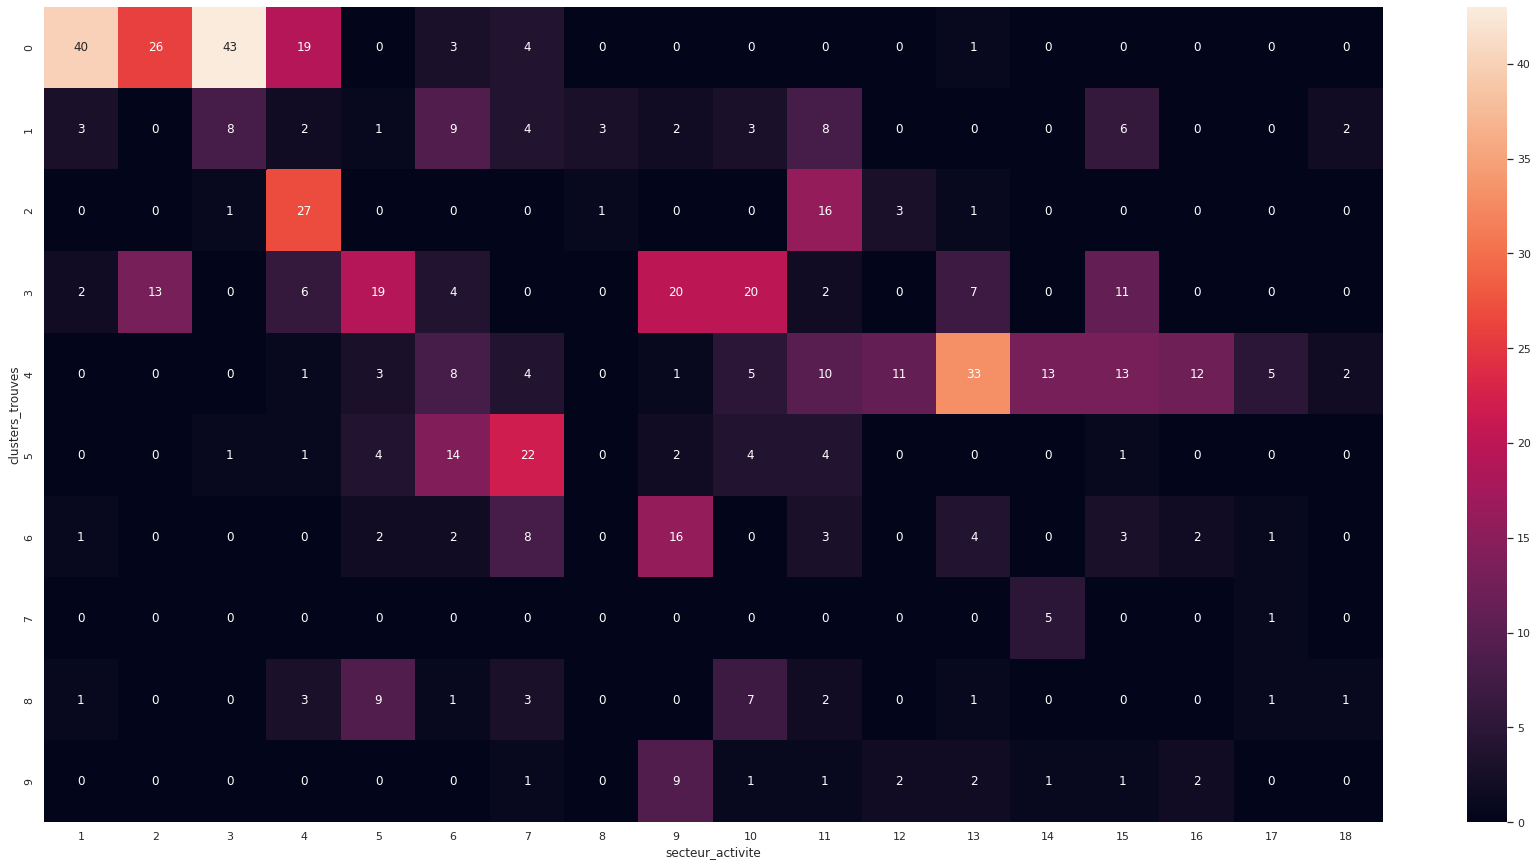

In [ ]:
# This cell allows us to merge the two dataframes that contain premade activity sectors, and use compare each one of them with each cluster we found with Louvain
# The number of matches is then converted into an adjacency matrix which is later on used to create a heatmap

def load_dataframe():
  # dataframe that contains the sector for each product
  df_sector = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/sector_for_nodes.csv', delimiter = ",", dtype={'code_hs4': str})
  # dataframe that contains all the 19 activity sectors and their description in french
  df_label = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/label_sector.csv', delimiter = ",")
  # Empty dataframe which will contain the number of matches
  df_clusters = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/clusters.csv', delimiter = "|")
  return df_sector, df_label, df_clusters


def french_description_clean(df_merged):
  # Here we clean the french descriptions
  for i, row in df_merged.iterrows():
    split = row["name"].split("""fr'"=>""")
    split_name = split[1]
    df_merged.at[i,'name'] = split_name
    df_merged.at[i,'name'] = df_merged.at[i,'name'].replace('"','')
    df_merged.at[i,'name'] = df_merged.at[i,'name'].replace("'",'')
  return df_merged


def calculate_number_matches(df_merged):
  # Here we calculate the number of matches between each activity sector and our clusters
  idx = 0
  total_match = []
  for i in range(1,19):
    cluster_pascal = df_merged.loc[df_merged['id'] == i]
    code_cluster_pascal = list(cluster_pascal.code_hs4)
    for j in range(0, maximum):
      nb_match = 0
      code_cluster_nous = [key for key, value in old_partition.items() if value == j]
      for m in range(0, len(code_cluster_pascal)):
        for l in range(0, len(code_cluster_nous)):
          if code_cluster_nous[l] == code_cluster_pascal[m]:
            nb_match += 1
            break
      total_match.append(nb_match)
      df_clusters.at[idx,'clusters_trouves'] = j
      df_clusters.at[idx,'secteur_activite'] = i
      df_clusters.at[idx,'match'] = nb_match
      idx+=1
  return df_clusters


def get_heatmap_from_dataframe(df_merged, df_clusters):
  df_merged = df_merged.drop_duplicates(subset=['code_hs4', 'id'], keep='first')
  df = pd.crosstab(df_clusters.clusters_trouves, df_clusters.secteur_activite, values = df_clusters.match, aggfunc=np.sum, dropna=False)
  sns.set(rc = {'figure.figsize':(30,15)})
  sns.heatmap(df, annot=True)


df_sector, df_label, df_clusters = load_dataframe()

df_merged_original = pd.merge(df_sector, df_label, on='id')

df_merged = french_description_clean(df_merged_original)


list_clusters = list(old_partition.keys())
df_merged = df_merged[df_merged['code_hs4'].isin(list_clusters)]

df_clusters = calculate_number_matches(df_merged)
  

get_heatmap_from_dataframe(df_merged, df_clusters)

In [ ]:
# We grab all the IDs of each line, to use afterwards for metric calculations (Activity Sectors)
list_id = df_merged['id'].tolist()
activity_sectors = list_id[:634]
print(activity_sectors)

# We grab all the IDs of each line, to use afterwards for metric calculations (Louvain)
label_louvain = list(partition.values())

# Score calculation between the clusters we found and the activity sectors
print(metrics.adjusted_rand_score(activity_sectors, label_louvain))
print(metrics.rand_score(activity_sectors, label_louvain))

print(metrics.adjusted_mutual_info_score(activity_sectors, label_louvain))
print(metrics.homogeneity_score(activity_sectors, label_louvain))
print(metrics.completeness_score(activity_sectors, label_louvain))
print(metrics.v_measure_score(activity_sectors, label_louvain))
print(metrics.fowlkes_mallows_score(activity_sectors, label_louvain))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 